In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,pipeline_modelagem,plot_comparacao_roc \
                    ,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao \
                    ,plot_comparacao_ks,plot_comparacao_decil,gerar_tabela_avaliacao,plotar_ks_safra \
                    ,calcular_ks_por_safra,monitorar_variaveis_continuas,obter_importancia_variaveis,calcular_metricas_multiplas


In [2]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train_selecionada.csv")

In [3]:
#lendo a base de teste oos
test_oos = pd.read_csv("test_oos.csv")
test_oos = test_oos[train_selecionada.columns]

In [4]:
#verificando o schema
train_selecionada.shape,test_oos.shape

((7315, 43), (1829, 43))

In [5]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [6]:
regra_imputacao = escolher_estrategia_imputacao(train_selecionada)
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oos = aplicar_imputacao_teste(test_oos,regra_imputacao, dict_mediana, dict_media)

In [7]:
train_selecionada.shape, test_oos.shape

((7315, 43), (1829, 43))

In [8]:
#7 min pra treinar com polinomial features
#
train_selecionada, test_oos, tuned_lightgbm, tuned_lr,train_lightgbm_escorado, \
test_lightgbm_escorado,train_regressao_escorado, test_regressao_escorado = pipeline_modelagem(train_selecionada, test_oos, id_col='id', safra_col='safra', target_col='y')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7206,0.7802,0.6595,0.5043,0.5712,0.3696,0.3772,0.1550
lightgbm,Light Gradient Boosting Machine,0.7702,0.7785,0.4739,0.6223,0.5374,0.3884,0.3951,0.3630


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7572,0.7620,0.4140,0.6016,0.4904,0.3381,0.3483
1,0.7785,0.8012,0.4892,0.6408,0.5549,0.4109,0.4175
2,0.7906,0.7905,0.4839,0.6818,0.5660,0.4332,0.4443
3,0.7432,0.7462,0.4486,0.5533,0.4955,0.3258,0.3290
4,0.7918,0.8060,0.5591,0.6541,0.6029,0.4630,0.4656
5,0.7599,0.7658,0.4301,0.6061,0.5031,0.3508,0.3598
6,0.7751,0.7874,0.4892,0.6319,0.5515,0.4046,0.4105
7,0.7675,0.7583,0.4409,0.6260,0.5174,0.3702,0.3801
8,0.7857,0.8087,0.5269,0.6490,0.5816,0.4397,0.4440


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7557,0.7610,0.5108,0.5758,0.5413,0.3756,0.3769
1,0.7648,0.7907,0.5538,0.5886,0.5706,0.4089,0.4092
2,0.7754,0.7879,0.5269,0.6203,0.5698,0.4192,0.4217
3,0.7508,0.7551,0.5459,0.5580,0.5519,0.3793,0.3794
4,0.7888,0.8175,0.5699,0.6424,0.6040,0.4606,0.4622
5,0.7401,0.7596,0.4194,0.5532,0.4771,0.3085,0.3137
6,0.7766,0.8028,0.5484,0.6182,0.5812,0.4296,0.4310
7,0.7523,0.7609,0.4570,0.5782,0.5105,0.3477,0.3520
8,0.7751,0.8096,0.5699,0.6092,0.5889,0.4343,0.4348


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7086,0.7687,0.6129,0.4872,0.5429,0.3331,0.3379
1,0.7527,0.8051,0.6882,0.5494,0.6110,0.4330,0.4389
2,0.7344,0.7977,0.6667,0.5232,0.5863,0.3949,0.4012
3,0.6824,0.7377,0.6378,0.4538,0.5303,0.3005,0.3105
4,0.7340,0.8098,0.7258,0.5212,0.6067,0.4139,0.4268
5,0.7112,0.7622,0.6452,0.4918,0.5581,0.3494,0.3565
6,0.7295,0.8015,0.6828,0.5163,0.5880,0.3923,0.4008
7,0.7052,0.7553,0.6183,0.4832,0.5425,0.3298,0.3352
8,0.7325,0.8118,0.7204,0.5194,0.6036,0.4097,0.4222


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7056,0.7680,0.6183,0.4832,0.5425,0.3302,0.3357
1,0.7496,0.8047,0.6828,0.5451,0.6062,0.4260,0.4318
2,0.7360,0.7977,0.6667,0.5254,0.5877,0.3975,0.4036
3,0.6824,0.7373,0.6432,0.4542,0.5324,0.3026,0.3131
4,0.7325,0.8104,0.7258,0.5192,0.6054,0.4114,0.4246
5,0.7067,0.7620,0.6398,0.4857,0.5522,0.3401,0.3473
6,0.7280,0.8017,0.6828,0.5142,0.5866,0.3898,0.3985
7,0.7052,0.7563,0.6183,0.4832,0.5425,0.3298,0.3352
8,0.7310,0.8122,0.7151,0.5175,0.6005,0.4055,0.4175


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,Logistic Regression,0.7206,0.7802,0.6595,0.5043,0.5712,0.3696,0.3772,0.0180
0,Light Gradient Boosting Machine,0.7627,0.7792,0.5213,0.5903,0.5529,0.3925,0.3943,0.0770



🏆 **Modelo Vencedor:** LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
✅ Regressão Logística escolhida com AUC: 0.7802


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7733,0.8011,0.5348,0.6132,0.5714,0.4183,0.4201


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7660,0.7860,0.5368,0.5944,0.5642,0.4048,0.4058


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7254,0.7836,0.6660,0.5106,0.5780,0.3797,0.3871


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7266,0.7843,0.6783,0.5117,0.5833,0.3858,0.3943


base escorada pycaret
         id   safra      VAR_15        VAR_9       VAR_54  VAR_3       VAR_5  \
0      7913  201405   80.410004   700.000000   700.000000    0.0   73.959999   
1      7343  201401   65.980003  1000.000000  1230.000000    1.0   68.980003   
2      9046  201407   49.980000  2209.000000  2209.000000    0.0   68.980003   
3      5227  201405   53.110001  1000.000000  1550.000000    0.0   70.470001   
4     10491  201404  157.649994  1479.390015  1479.390015    0.0   68.980003   
...     ...     ...         ...          ...          ...    ...         ...   
7310  10447  201402   52.380001   500.000000  1230.000000    0.0   67.629997   
7311   2189  201402   49.980000  1000.000000  1000.000000    0.0   18.410000   
7312   6839  201409   52.430000  1000.000000  2000.000000    0.0  127.599998   
7313   1422  201409   59.980000   900.000000   900.000000    1.0   68.980003   
7314   5592  201408   26.389999  1000.000000  2200.000000    0.0   16.260000   

      VAR_1  VAR_

In [9]:
#Ler a base OOT
test_oot = pd.read_csv('teste_oot.csv')
test_oot = test_oot[train_selecionada.columns]

In [10]:
test_oot.shape

(1594, 43)

In [11]:
#### Escoragem dos Modelos no dataset de OOT ####
#Primeiro vamos aplicar a regra de imputação de missings
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oot = aplicar_imputacao_teste(test_oot,regra_imputacao, dict_mediana, dict_media)


In [12]:
#Agora basta escorar a base oot nos dois modelos

# 🔹 ESCORAGEM DOS MODELOS

# Aplicando LightGBM no conjunto de treino e teste
test_oot_lightgbm = predict_model(tuned_lightgbm, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_lightgbm = test_oot_lightgbm[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6838,0.7019,0.2527,0.5897,0.3538,0.1867,0.2161


In [13]:
test_oot_regressao = predict_model(tuned_lr, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_regressao = test_oot_regressao[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6851,0.7046,0.4451,0.5498,0.4919,0.2674,0.2705


In [14]:
train_lightgbm_escorado.head()

,id,safra,y,score_1,score_0
0,7913,201405,0,0.1424,0.8576
1,7343,201401,1,0.9117,0.0883
2,9046,201407,1,0.6788,0.3212
3,5227,201405,0,0.3361,0.6639
4,10491,201404,1,0.5352,0.4648


In [15]:
test_oot_regressao.head()

,id,safra,y,score_0,score_1
0,4,201412,0,0.6031,0.3969
1,13,201411,1,0.5793,0.4207
2,15,201412,0,0.4697,0.5303
3,17,201412,0,0.1150,0.8850
4,20,201411,0,0.6882,0.3118


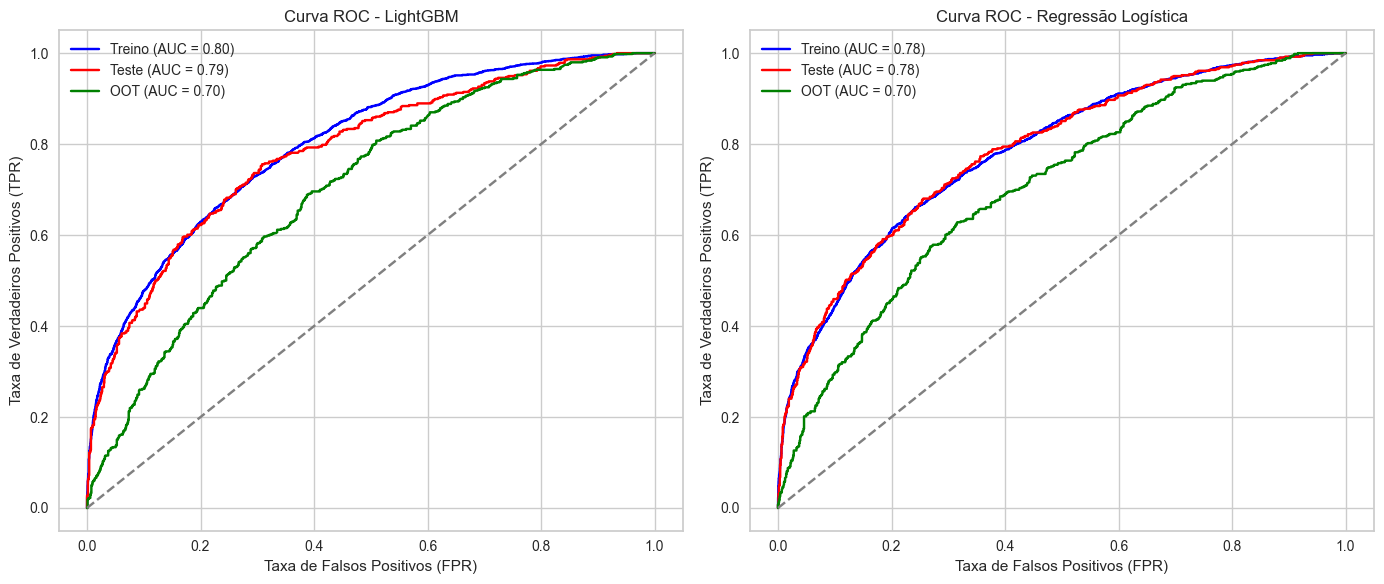

In [16]:
#1. Curva ROC (Receiver Operating Characteristic)
#Mostra a relação entre Taxa de Verdadeiros Positivos (TPR - Sensibilidade) e Taxa de Falsos Positivos (FPR).
#Quanto mais próxima a curva estiver do canto superior esquerdo, melhor o modelo.
#A métrica principal associada é a AUC-ROC (Área sob a Curva ROC), que indica a capacidade do modelo em distinguir classes.
#Usar com objetivo for avaliar o quão bem o modelo separa as classes, independentemente da distribuição dos dados.

plot_comparacao_roc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

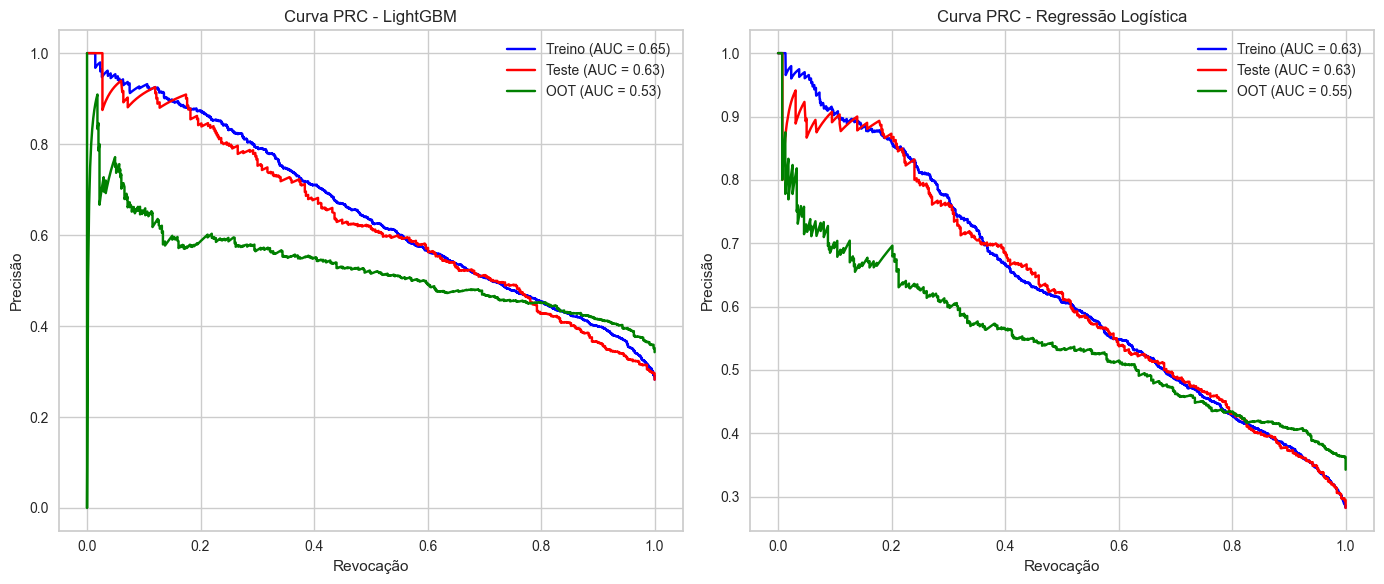

In [17]:
#2. Curva PRC (Precision-Recall Curve)
#Mostra a relação entre Precisão (Precision) e Revocação (Recall - Sensibilidade).
#Útil quando a classe positiva é rara (dados desbalanceados).
#A métrica associada é a AUC-PR, que mede a área sob essa curva.
#Se houver um grande desbalanceamento entre as classes (por exemplo, detecção de fraudes, doenças raras).

plot_comparacao_prc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

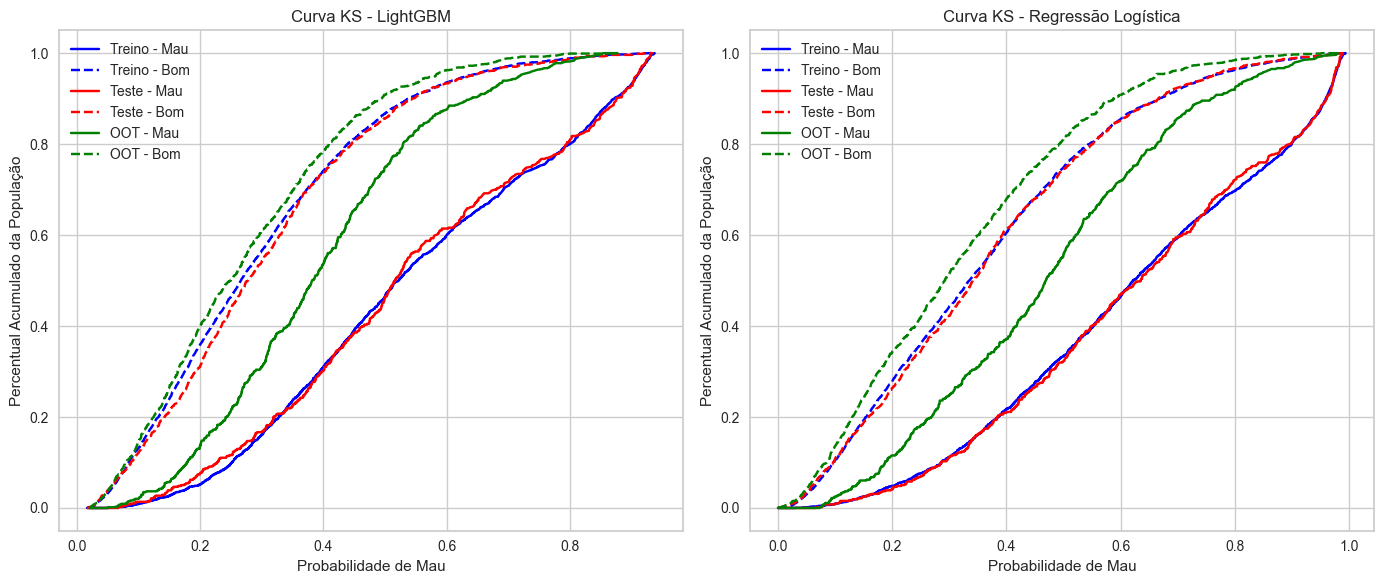

In [18]:
#3. Curva KS (Kolmogorov-Smirnov Curve)
#Mede a diferença máxima entre as distribuições cumulativas de positivos e negativos.
#Quanto maior o valor de KS, melhor a separação do modelo.
#Muito utilizada em modelos de risco de crédito e em cenários onde se quer saber o ponto de máxima separação entre as classes.

plot_comparacao_ks(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

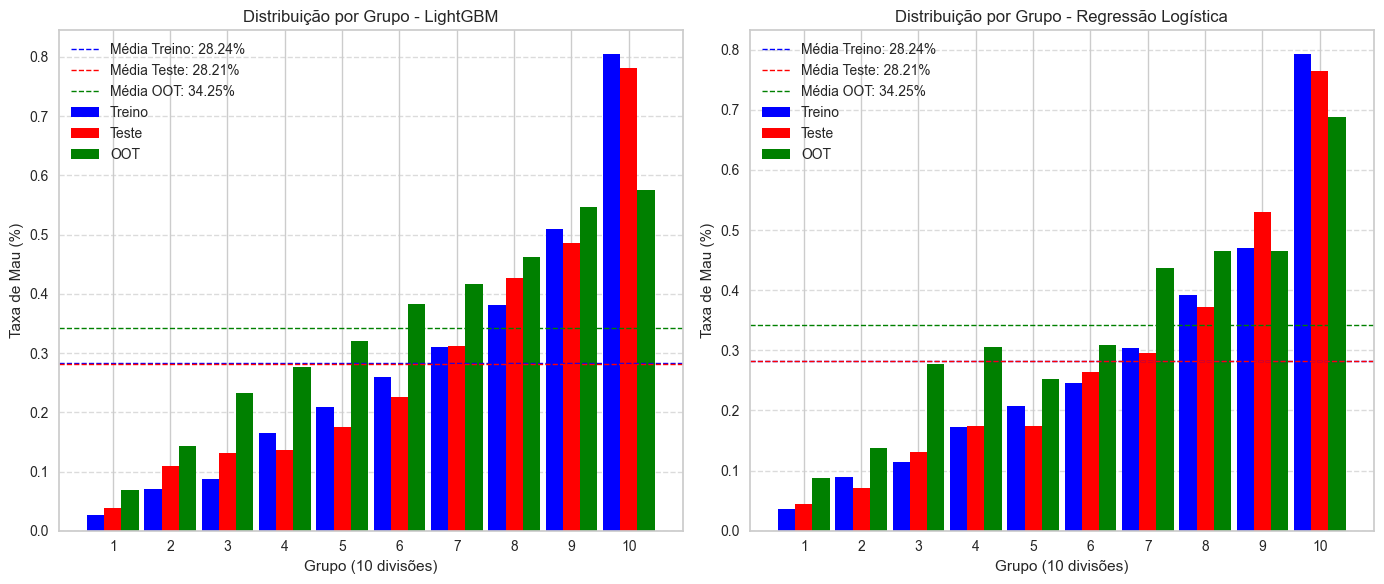

In [19]:
#Verificar se o score está ordenando bem e seguindo uma lógica onde quanto maior a probabilidade de mau, maior o % de maus acumulados
#Ordenamos o score do menor para o maior 
#Criamos faixas discretas e verificamos a quantidade de maus em cada faixa
#Quanto mais ordenadas forem as faixas melhor
plot_comparacao_decil(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [20]:
tabela = gerar_tabela_avaliacao(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [21]:
tabela['nome_dataframe'].unique().tolist()

['Train LightGBM',
 'Test LightGBM',
 'Train Regressão',
 'Test Regressão',
 'OOT LightGBM',
 'OOT Regressão']

In [22]:
tabela[tabela['nome_dataframe']=="OOT LightGBM"].head(10)

,nome_dataframe,quantil,score_0 min,score_0 max,total_casos,total_mau,total_bom,maus_acumulados,% maus acumulados,KS
40,OOT LightGBM,1,0.9014,0.9791,160,11,149,11,2.014652,12.202905
41,OOT LightGBM,2,0.8470,0.9010,160,23,137,34,6.227106,21.062970
42,OOT LightGBM,3,0.8046,0.8468,159,37,122,71,13.003663,25.927635
43,OOT LightGBM,4,0.7516,0.8035,159,44,115,115,21.062271,28.842309
44,OOT LightGBM,5,0.7035,0.7508,159,51,108,166,30.402930,29.806993
45,OOT LightGBM,6,0.6511,0.7033,159,61,98,227,41.575092,27.985977
46,OOT LightGBM,7,0.5993,0.6509,161,67,94,294,53.846154,24.684381
47,OOT LightGBM,8,0.5385,0.5990,158,73,85,367,67.216117,19.425104
48,OOT LightGBM,9,0.4462,0.5381,159,87,72,454,83.150183,10.361267
49,OOT LightGBM,10,0.1224,0.4459,160,92,68,546,100.000000,0.000000


In [23]:
#ks por safra publico completo lightgbm
tabela_ks = calcular_ks_por_safra(pd.concat([train_lightgbm_escorado,test_lightgbm_escorado,test_oot_lightgbm]))

In [24]:
tabela_ks

,safra,contagem_de_linhas,ks_max,ponto_ks
0,201401,854,50.721689,0.5127
1,201402,898,49.219908,0.5541
2,201403,873,53.694168,0.4750
3,201404,955,48.130884,0.3782
4,201405,972,45.679477,0.3928
5,201406,902,49.679812,0.3577
6,201407,968,42.136669,0.4067
7,201408,912,41.835031,0.3155
8,201409,877,43.577612,0.3584
9,201410,933,40.774538,0.3352


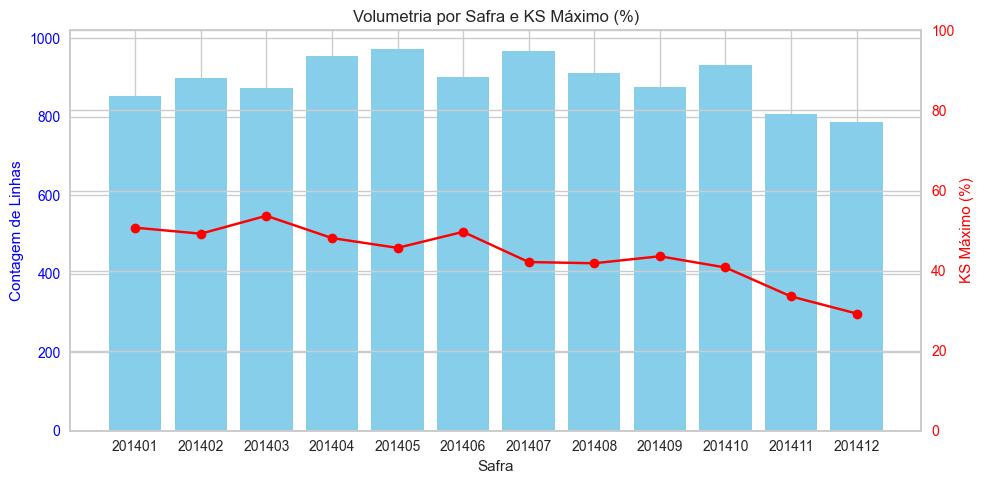

In [25]:
plotar_ks_safra(tabela_ks)

In [26]:
# O que leva nosso modelo a perder performance no OOT?
#Se o modelo perdeu performance no OOT, algumas causas podem ser:
#
#Mudança nos dados – Os padrões dos dados mudaram com o tempo.
#Mudança na relação com a target – As variáveis deixaram de influenciar o resultado da mesma forma.
#Overfitting – O modelo aprendeu muito bem o treino, mas não generaliza para novos períodos.
#Dados desatualizados – O treino foi feito com dados antigos e não reflete a realidade atual.
#Erros no processamento – Alguma transformação nos dados do OOT pode estar errada.
#Fatores externos – Eventos novos afetaram o comportamento dos dados (ex: crise, novas regras).

In [27]:
#Importancia de variáveis non light gbm (quantas vezes a variável foi utilizada para realizar o corte na folha da árvore)
#Os betas (β) na Regressão Logística são os coeficientes que medem o efeito de cada variável independente na probabilidade de um determinado evento ocorrer.

df_lgbm_vars = obter_importancia_variaveis(tuned_lightgbm, "LightGBM")
df_logistica_vars = obter_importancia_variaveis(tuned_lr, "Regressão Logística")

In [28]:
#Se uma variável que é importante para o modelo muda de distribuição, isso pode causar problemas na previsão.

#O p-valor mede a probabilidade de observarmos uma diferença tão grande entre duas amostras apenas por acaso, assumindo que elas vêm da mesma distribuição.
#Se p-valor < 0.05 → Existe menos de 5% de chance de que a diferença seja mero acaso. Ou seja, há evidências estatísticas de que as distribuições são diferentes!
#Se p-valor >= 0.05 → Não há evidências suficientes para afirmar que as distribuições mudaram.
#No caso do KS Test (Kolmogorov-Smirnov), um p-valor < 0.05 indica que a distribuição da variável mudou significativamente entre a safra de referência e a safra atual.

#O PSI (Índice de Estabilidade Populacional) mede a diferença entre duas distribuições.
#Dividimos os dados em faixas de valores, Calculamos as frequências relativas em cada bin para ambas as populações (referência e atual).
#PSI < 0.1 → Pequena diferença (distribuição estável)
#0.1 ≤ PSI < 0.25 → Diferença moderada (monitorar)
#PSI ≥ 0.25 → Diferença significativa (possível problema )


psi,ks = monitorar_variaveis_continuas(pd.concat([train_selecionada,test_oos]), test_oot, [x for x in train_selecionada.columns if x not in ['id','safra','y']])

In [29]:
reprovadas_ks = ks.index.tolist()
reprovadas_psi = psi.index.tolist()

In [30]:
reprovadas = reprovadas_ks + reprovadas_psi

In [31]:
reprovadas

['VAR_15',
 'VAR_9',
 'VAR_54',
 'VAR_3',
 'VAR_5',
 'VAR_1',
 'VAR_28',
 'VAR_60',
 'VAR_58',
 'VAR_17',
 'VAR_30',
 'VAR_2',
 'VAR_59',
 'VAR_53',
 'VAR_20',
 'VAR_57',
 'VAR_44',
 'VAR_52',
 'VAR_76',
 'VAR_4']

In [32]:
avaliar_vars_ks = df_lgbm_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [33]:
avaliar_vars = avaliar_vars_ks.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [34]:
#verificando facilmente como a média da variável VAR_1 mudou nos meses mais recentes do OOT
train_selecionada['VAR_1'].mean(),test_oos['VAR_1'].mean(),test_oot['VAR_1'].mean()

(34.32781954887218, 33.11591033351558, 22.331869510664994)

In [35]:
avaliar_vars

,nome_variavel,importancia,index_x,KS_Stat,p_value,Alerta,index_y
0,VAR_9,138,VAR_9,0.059372,1.328279e-04,Mudança Significativa,NaN
1,VAR_20,121,VAR_20,0.054539,5.952341e-04,Mudança Significativa,NaN
2,VAR_60,114,VAR_60,0.037630,4.158844e-02,Mudança Significativa,NaN
3,VAR_1,104,VAR_1,0.100448,2.242497e-12,Mudança Significativa,NaN
4,VAR_4,91,VAR_4,0.098673,5.880614e-12,Mudança Significativa,NaN
5,VAR_32,86,NaN,NaN,NaN,NaN,NaN
6,VAR_3,66,VAR_3,0.082740,1.559635e-08,Mudança Significativa,NaN
7,VAR_72,55,NaN,NaN,NaN,NaN,NaN
8,VAR_64,54,NaN,NaN,NaN,NaN,NaN
9,VAR_65,51,NaN,NaN,NaN,NaN,NaN


In [36]:
avaliar_vars_ks_lr = df_logistica_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [37]:
avaliar_vars_lr = avaliar_vars_ks_lr.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [38]:
avaliar_vars_lr

,nome_variavel,importancia,index_x,KS_Stat,p_value,Alerta,index_y
0,VAR_1,1.272131,VAR_1,0.100448,2.242497e-12,Mudança Significativa,NaN
1,VAR_9,0.481000,VAR_9,0.059372,1.328279e-04,Mudança Significativa,NaN
2,VAR_20,0.456616,VAR_20,0.054539,5.952341e-04,Mudança Significativa,NaN
3,VAR_6,-0.334678,NaN,NaN,NaN,NaN,NaN
4,VAR_60,-0.266144,VAR_60,0.037630,4.158844e-02,Mudança Significativa,NaN
5,VAR_17,-0.232191,VAR_17,0.063310,3.561600e-05,Mudança Significativa,NaN
6,VAR_32,-0.179072,NaN,NaN,NaN,NaN,NaN
7,VAR_2,-0.178009,VAR_2,0.065338,1.749860e-05,Mudança Significativa,NaN
8,VAR_44,-0.168277,VAR_44,0.037958,3.886908e-02,Mudança Significativa,NaN
9,VAR_76,-0.140715,VAR_76,0.042499,1.436223e-02,Mudança Significativa,NaN


In [39]:
# Vamos salvar as bases escoradas para podermos avaliar melhor o modelo com métricas que dependem do Limiar de corte

#train_lightgbm_escorado.to_csv("train_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_lightgbm_escorado.to_csv("test_lightgbm_escorado.csv",sep=",",index=False,header=True)
#train_regressao_escorado.to_csv("train_regressao_escorado.csv",sep=",",index=False,header=True)
#test_regressao_escorado.to_csv("test_regressao_escorado.csv",sep=",",index=False,header=True)
#test_oot_lightgbm.to_csv("test_oot_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_oot_regressao.to_csv("test_oot_regressao_escorado.csv",sep=",",index=False,header=True)

In [40]:
bases_nomeadas = {
    "Train - LightGBM": train_lightgbm_escorado,
    "Test - LightGBM": test_lightgbm_escorado,
    "OOT - LightGBM": test_oot_lightgbm,
    "Train - Regressão Logística": train_regressao_escorado,
    "Test - Regressão Logística": test_regressao_escorado,
    "OOT - Regressão Logística": test_oot_regressao
}
calcular_metricas_multiplas(bases_nomeadas, limiar = 0.3)

,Nome da Base,Acurácia,Precisão,Recall,F1-score,AUC,KS MAX,GINI,TP,FP,TN,FN
0,Train - LightGBM,0.6427,0.4318,0.8398,0.5703,0.8011,0.4352,0.6023,1735,2283,2966,331
1,Test - LightGBM,0.6238,0.4167,0.8333,0.5556,0.7860,0.4474,0.5720,430,602,711,86
2,OOT - LightGBM,0.6368,0.4790,0.6905,0.5656,0.7019,0.3012,0.4038,377,410,638,169
3,Train - Regressão Logística,0.5690,0.3857,0.8882,0.5379,0.7836,0.4198,0.5672,1835,2922,2327,231
4,Test - Regressão Logística,0.5544,0.3772,0.8895,0.5297,0.7843,0.4243,0.5687,459,758,555,57
5,OOT - Regressão Logística,0.5966,0.4472,0.7527,0.5611,0.7046,0.3124,0.4091,411,508,540,135


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optbinning import OptimalBinning
from sklearn.cluster import KMeans
from typing import Tuple

def woe_binning_and_stability_analysis(
    df: pd.DataFrame, 
    variable: str, 
    target: str, 
    time_variable: str, 
    n_clusters: int = 4
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Realiza o binning por WOE, analisa a estabilidade dos bins ao longo do tempo
    e agrupa bins semelhantes para manter a estabilidade.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame contendo os dados.
    variable : str
        Nome da variável contínua a ser agrupada em bins.
    target : str
        Nome da variável alvo binária (0 ou 1).
    time_variable : str
        Nome da variável que representa as safras (tempo discreto).
    n_clusters : int, opcional
        Número de clusters para agrupar bins semelhantes (padrão: 4).

    Retorna:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        - DataFrame com os dados originais + bins antes da agregação.
        - DataFrame com os bins após a agregação inteligente.
    """

    # 1️⃣ Binning por WOE usando OptBinning
    binning = OptimalBinning(name=variable, dtype="numerical", solver="cp")
    binning.fit(df[variable], df[target])
    df["bin"] = binning.transform(df[variable], metric="bins")

    # 2️⃣ Criando DataFrame para análise de estabilidade
    stability_df = df.groupby([time_variable, "bin"]).size().unstack().fillna(0)
    stability_df = stability_df.div(stability_df.sum(axis=1), axis=0)  # Normaliza por período

    # 3️⃣ Clusterizando bins com comportamento semelhante
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    bin_clusters = kmeans.fit_predict(stability_df.T)

    # Criando um dicionário para mapear bins para clusters
    bin_map = {bin_label: f"Grupo_{cluster}" for bin_label, cluster in zip(stability_df.columns, bin_clusters)}
    df["bin_agrupado"] = df["bin"].map(bin_map)

    # 4️⃣ Criando DataFrame para análise pós-agrupamento
    stability_grouped_df = df.groupby([time_variable, "bin_agrupado"]).size().unstack().fillna(0)
    stability_grouped_df = stability_grouped_df.div(stability_grouped_df.sum(axis=1), axis=0)

    # 5️⃣ Plotando gráficos de estabilidade antes e depois do agrupamento
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 🔹 Antes do agrupamento
    stability_df.plot(ax=axes[0], marker='o')
    axes[0].set_title("Distribuição dos Bins ao Longo do Tempo (Antes do Agrupamento)")
    axes[0].set_ylabel("Proporção")
    axes[0].set_xlabel("Safra")
    axes[0].legend(title="Bins", bbox_to_anchor=(1.05, 1), loc='upper left')

    # 🔹 Depois do agrupamento
    stability_grouped_df.plot(ax=axes[1], marker='o', cmap="tab10")
    axes[1].set_title("Distribuição dos Bins ao Longo do Tempo (Depois do Agrupamento)")
    axes[1].set_ylabel("Proporção")
    axes[1].set_xlabel("Safra")
    axes[1].legend(title="Grupos", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return df, stability_grouped_df


(CVXPY) Feb 07 09:26:23 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 07 09:26:23 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [44]:
train_selecionada.shape

(7315, 43)

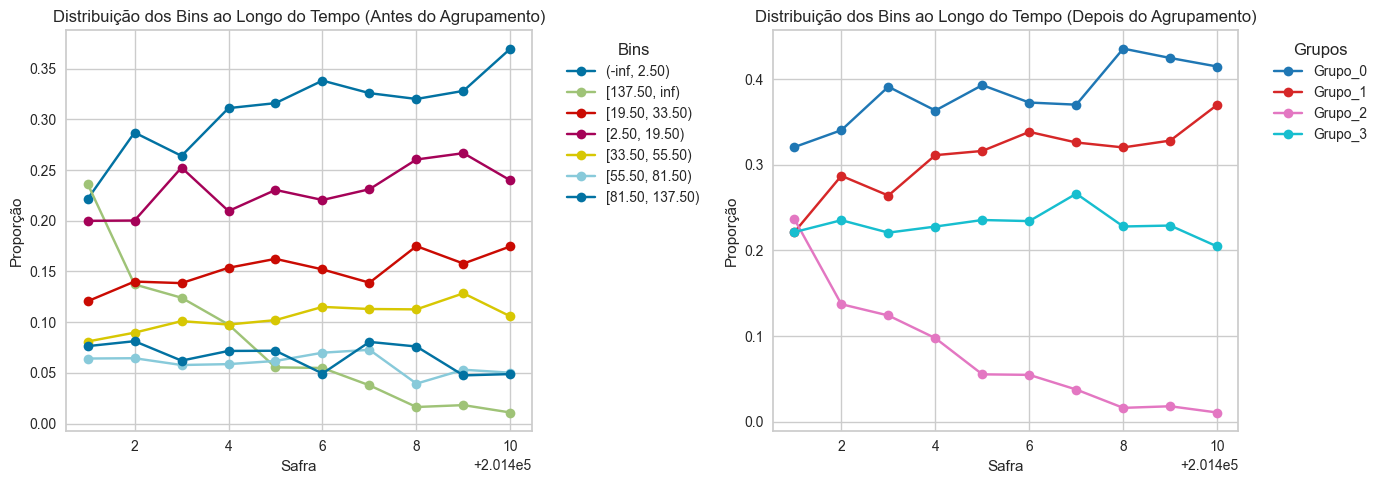

In [45]:
df_result, stability_grouped_df = woe_binning_and_stability_analysis(
                                                                    df=train_selecionada, 
                                                                    variable="VAR_1", 
                                                                    target="y",
                                                                    time_variable="safra"
                                                                    )

In [46]:
stability_grouped_df

bin_agrupado,Grupo_0,Grupo_1,Grupo_2,Grupo_3
safra,,,,
201401,0.320611,0.221374,0.236641,0.221374
201402,0.340336,0.287115,0.137255,0.235294
201403,0.391053,0.264069,0.124098,0.220779
201404,0.363281,0.311198,0.097656,0.227865
201405,0.392947,0.316121,0.055416,0.235516
201406,0.372603,0.338356,0.054795,0.234247
201407,0.370130,0.325974,0.037662,0.266234
201408,0.435550,0.320217,0.016282,0.227951
201409,0.424581,0.328212,0.018156,0.229050


In [ ]:
############ TESTAR ESSA FUNCAO DE BINNING

In [ ]:
# 🔹 Criando dataset de treino
np.random.seed(42)
df_train = pd.DataFrame({
    "score": np.random.normal(600, 50, 1000),
    "default": np.random.choice([0, 1], p=[0.8, 0.2], size=1000),
    "safra": np.random.choice(["2021_Q1", "2021_Q2", "2021_Q3", "2021_Q4"], size=1000)
})

# 🔹 Treinando o binning
df_train_binned, rules = train_woe_binning(df_train, "score", "default", "safra")

# 🔹 Criando dataset de teste
df_test = pd.DataFrame({
    "score": np.random.normal(600, 50, 500)
})

# 🔹 Aplicando os bins ao dataset de teste
df_test_binned = apply_woe_binning(df_test, "score", rules)

# 🔹 Exibindo os primeiros resultados
df_test_binned.head()
